In [1]:
import sys
# !{sys.executable} -m pip install openbabel
from collections import Counter
from shutil import move
from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
from scipy.spatial import distance_matrix

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import offline

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 0

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
import xyz2graph
xyz2graph.__path__

['/Users/grierjones/miniconda3/lib/python3.12/site-packages/xyz2graph']

# Find an automated way to determine the interaction sites of a dipeptide

In [3]:
# Useful data
ptable = fetch_table('elements').set_index('symbol')
Z={v:k for k,v in ptable['atomic_number'].to_dict().items()}

In [4]:
aa_dictog={'Glycine':"O=C(O)CN",
 'Arginine':"O=C(O)[C@H](CCCNC(N)=N)N",
 'Aspartic':"O=C(O)[C@H](CC(O)=O)N",
 'Alanine':"O=C(O)[C@H](C)N",
 'Threonine':"O=C(O)[C@H]([C@H](O)C)N",
 'Phenylalanine':"O=C(O)[C@H](CC1=CC=CC=C1)N",
 'Leucine':"O=C(O)[C@H](CC(C)C)N",
 'Lysine':"O=C(O)[C@H](CCCCN)N",
 # 'Histidine':"NC(c1cnc[nH]1)C(=O)O",# Wrong structure but use for code testing for now
 'Histidine':"O=C(O)[C@H](CC1=CNC=N1)N",
 'Cysteine':"O=C(O)[C@H](CS)N",
 'Glutamine':"O=C(O)[C@H](CCC(N)=O)N",
 'Methionine':"O=C(O)[C@H](CCSC)N",
 'Tryptophan':"O=C(O)[C@H](CC1=CNC2=CC=CC=C12)N",
 'Serine':"O=C(O)[C@H](CO)N",
 'Glutamic':"O=C(O)[C@H](CCC(O)=O)N",
 'Proline':"O=C(O)[C@H]1NCCC1",
 'Asparagine':"O=C(O)[C@H](CC(N)=O)N",
 'Valine':"O=C(O)[C@H](C(C)C)N",
 'Tyrosine':"O=C(O)[C@H](CC1=CC=C(C=C1)O)N",
 'Isoleucine':"O=C(O)[C@H]([C@@H](C)CC)N"}
aa_dict={}
for k,v in aa_dictog.items():
    if k!='Glycine':
        mol=Chem.MolFromSmiles(v)
        Chem.RemoveStereochemistry(mol)
        aa_dict[k]=Chem.MolToSmiles(mol)
    else:
        aa_dict[k]=v

In [5]:
# Find set of files

co2files=glob('./dipeptides_co2_coordinates/*.xyz')

y=pd.read_excel('400_dipeptides_interaction_energy_UPDATED2.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]

# Pairs: 
# In the dehydration process,
# AA1 is the one that undergoes dehydroxylation
# and AA2 is the one that undergoes dehydrogenation
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","")) for i in pd.read_excel('400_dipeptides_interaction_energy_UPDATED2.xlsx', 'Sheet2',header=None).values]).set_index(0)

for idx,i in enumerate(pairs[1].values):
    if 'acid' in i:
        pairs[1].iloc[idx]=i.replace('acid','')


ptable = fetch_table('elements').set_index('symbol')
AAs=list(set(sum([i[0].split('-') for i in pairs.values],[])))

monomerfiles={}        
co2paths={}
for k,v in pairs.to_dict()[1].items():
    try:
        path=glob(f'./dipeptides_co2_coordinates/{k}_*.xyz')[0]
        monpath=f'./dipeptides_coordinates/{k}.xyz'
        if os.path.exists(path) and os.path.exists(monpath):
            co2paths[v]=path    
            monomerfiles[v]=monpath
    except:
        print(k)

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3485/176667601.py:16: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [6]:

# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(co2files[0])

# # Create the Plotly figure object
# fig = to_plotly_figure(mg)

# # Plot the figure
# offline.plot(fig)

# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

In [7]:
def genxyz(filename):
    """
    Generate xyz file as numpy arrays
    
    parameters
    ----------
    filename: str
        Path to xyz file
        
    returns
    -------
    atoms: np.ndarray (str)
    
    xyz: np.ndarray (float)
    """
    file=np.genfromtxt(filename,skip_header=2,dtype=str)

    atoms=file[:,0]
    xyz=file[:,1:].astype(float)
    
    return atoms, xyz


def gendistmat(xyz):
    """
    Generate distance matrix from xyz array
    
    parameters
    ----------
    xyz: np.ndarray
    
    returns
    -------
    D: np.ndarray
    """
    atoms=xyz[0]
    xyz=xyz[1]
    D=distance_matrix(xyz,xyz)
    D=pd.DataFrame(D)
    return atoms,D

def closest(atms,distmat):
    clsdf=distmat.iloc[-3:,:-3].T.idxmin().to_frame()
    close=atms[clsdf.values]
    clsdf['atoms']=close
    clsdf=clsdf.rename(columns={0:'idx'})
    if dict(Counter(atms[clsdf.index]))=={'C':1,'O':2}:        
        return clsdf
    else:
        return None

In [8]:
pairs[pairs[1]=='Asparagine-Leucine']

,1
0,
AA_AA_51,Asparagine-Leucine


In [9]:
inter_dict={pairs.to_dict()[1]['_'.join(i.split('/')[-1].split('_')[0:3])]:closest(*gendistmat(genxyz(i))) for i in co2files}

In [10]:

co2dipepgraphs={}
co2mgs={}
for k,v in co2paths.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    co2mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    co2dipepgraphs[k]=G
    
dipepgraphs={}    
mgs={}
for k,v in monomerfiles.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    dipepgraphs[k]=G    


In [11]:
fig = to_plotly_figure(mgs['Asparagine-Leucine'])
offline.plot(fig)

'temp-plot.html'

In [12]:
# define the function for coverting rdkit object to networkx object -----------     
# From: https://gist.github.com/fangkuoyu/dc785218e5d4d94c752e80f1aaba4fad
def mol_to_nx(mol):
    mol=AllChem.AddHs(mol)
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G


def mol_to_nx_noHs(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

def draw_aminoacid(G):
    attrkeys=list(dict(G.nodes(data=True)).values())[0].keys()
    if 'element' in attrkeys:
        attkey='element'
        
    else:
        attkey='atom_symbol'
    atom = nx.get_node_attributes(G, attkey)
    color_map = {'C': '#696969',
                 'O': 'red',
                 'N': 'blue',
                 'H': '#F2F2F2',
                 'S': 'yellow'
                }

    colors = []
    for idx in G.nodes():
        if (G.nodes[idx][attkey] in color_map):
            colors.append(color_map[G.nodes[idx][attkey]])            
        else:
            colors.append('gray')

    nx.draw_spring(G,
            labels=atom,
            with_labels = True,
            node_color=colors,
            node_size=800)

    plt.show()


In [13]:
def MolFromGraphs(G):
    node_list=dict(G.nodes(data=True))
    
    adjacency_matrix=nx.adjacency_matrix(G).toarray()
    # create empty editable mol object
    mol = Chem.RWMol()

    # add atoms to mol and keep track of index
    node_to_idx = {}
    for i in range(len(node_list)):
        a = Chem.Atom(node_list[i]['element'])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    # add bonds between adjacent atoms
    for ix, iy in G.edges():
        nix=node_list[ix]
        niy=node_list[iy]
        
        single=np.round((ptable.loc[nix['element']]['covalent_radius_cordero']+ptable.loc[niy['element']]['covalent_radius_cordero'])/100,2)
        double=np.round((ptable.loc[nix['element']]['covalent_radius_pyykko_double']+ptable.loc[niy['element']]['covalent_radius_pyykko_double'])/100,2)
        bl=np.round(np.linalg.norm(np.array(nix['xyz'])-np.array(niy['xyz'])),2)
        if np.isclose(single,bl,atol=1e-1):
            # if nix['element']=='N' or niy['element']=='N':
            # print(ix,iy,nix['element'],niy['element'])
            # print('Single',single,double,bl,np.isclose(single,bl),np.isclose(double,bl,atol=1e-1))    
            # print()
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif np.isclose(double,bl,atol=1e-1):
            # print(ix,iy,nix['element'],niy['element'])
            # print('Double',single,double,bl)    
            # print()
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
            
        else:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)            
            

    mol = mol.GetMol()
    return mol

In [14]:
# MolFromGraphs(dipepgraphs[k])

In [15]:
# Make amino acid A (one that undergoes dehydroxylation)
dehydroxy={}
for k,v in aa_dict.items():
    m=Chem.MolFromSmiles(v)
    substructure = Chem.MolFromSmiles("O=C(O)CN")
    matches=m.GetSubstructMatch(substructure)


    n=Chem.EditableMol(m)
    for atom in m.GetAtoms():
        for i in matches:
            if atom.GetIdx()==i and atom.GetSymbol()=='O' and atom.GetTotalNumHs()==1: 
                n.RemoveAtom(atom.GetIdx())
    m=n.GetMol()
    dehydroxy[k]=m
    
    
    
dehydrogen={}
for idx,(k,v) in enumerate(aa_dict.items()):
    m=Chem.MolFromSmiles(v)
    substructure = Chem.MolFromSmiles("O=C(O)CN")
    matches=m.GetSubstructMatch(substructure)


    for atom in m.GetAtoms():
        for i in matches:
            if atom.GetIdx()==i and atom.GetSymbol()=='N': 
                atom.SetNoImplicit(True)
                if k!='Proline':
                    atom.SetNumExplicitHs(1)
    dehydrogen[k]=m    
# Draw.MolsToGridImage(dehydroxy.values(),molsPerRow=5, subImgSize=(300,300),legends=dehydroxy.keys())    
# Draw.MolsToGridImage(dehydrogen.values(),molsPerRow=5, subImgSize=(300,300),legends=dehydrogen.keys())    

In [16]:
# m=Chem.MolFromSmiles(aa_dict['Lysine'])
# substructure = Chem.MolFromSmiles("O=C(O)CN")
# matches=m.GetSubstructMatch(substructure)
# n=Chem.EditableMol(m)
# for atom in m.GetAtoms():
#     for i in matches:
#         if atom.GetIdx()==i and atom.GetSymbol()=='N': 
#             print(atom.SetNoImplicit(True))
#             print(atom.SetNumExplicitHs(1))
#             print(atom.GetIdx(),atom.GetSymbol(),atom.GetTotalNumHs())


In [17]:
mols={}
for k,m in monomerfiles.items():
    mol=Chem.AddHs(Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]))
    Chem.RemoveStereochemistry(mol)
    mols[k]=mol


aa_mols={k:Chem.MolFromSmiles(v) for k,v in aa_dict.items()}
g=Draw.MolsToGridImage(list(mols.values()),molsPerRow=10, subImgSize=(200,200),maxMols=400,legends=mols.keys())
# with open("dipeptides.png", "wb") as png:
#     png.write(g.data)
# Draw.MolsToGridImage(list(aa_mols.values()),molsPerRow=5, subImgSize=(300,300),legends=list(aa_mols.keys()))

In [18]:
hist_check={k:v for k,v in mols.items() if 'Histidine' in k}

In [19]:
# g=Draw.MolsToGridImage(hist_check.values(),molsPerRow=5, subImgSize=(300,300),legends=hist_check.keys())   
# with open("histidines.png", "wb") as png:
#     png.write(g.data)


In [20]:
# Check interaction positions
qc=[]
for idx,(k,v) in enumerate(dipepgraphs.items()):
    inds=[]
    atoms=[]
    print(idx,k,v)
    for atom in MolFromGraphs(v).GetAtoms():
        if atom.GetIdx() in inter_dict[k]['idx'].values:
            inds.append(atom.GetIdx())
            atoms.append(atom.GetSymbol())
    if set(inter_dict[k].atoms.values)==set(atoms) and set(inter_dict[k].idx.values)==set(inds):
        qc.append(True)
    else:
        qc.append(False)


0 Alanine-Alanine Graph with 23 nodes and 22 edges
1 Alanine-Arginine Graph with 36 nodes and 35 edges
2 Alanine-Asparagine Graph with 27 nodes and 26 edges
3 Alanine-Aspartic Graph with 26 nodes and 25 edges
4 Alanine-Cysteine Graph with 24 nodes and 23 edges
5 Alanine-Glutamic Graph with 29 nodes and 28 edges
6 Alanine-Glutamine Graph with 30 nodes and 29 edges
7 Alanine-Glycine Graph with 20 nodes and 19 edges
8 Alanine-Histidine Graph with 30 nodes and 30 edges
9 Alanine-Isoleucine Graph with 32 nodes and 31 edges
10 Alanine-Leucine Graph with 32 nodes and 31 edges
11 Alanine-Lysine Graph with 34 nodes and 33 edges
12 Alanine-Methionine Graph with 30 nodes and 29 edges
13 Alanine-Phenylalanine Graph with 33 nodes and 33 edges
14 Alanine-Proline Graph with 27 nodes and 27 edges
15 Alanine-Serine Graph with 24 nodes and 23 edges
16 Alanine-Threonine Graph with 27 nodes and 26 edges
17 Alanine-Tryptophan Graph with 37 nodes and 38 edges
18 Alanine-Tyrosine Graph with 34 nodes and 34 e

In [21]:
pairs[pairs[1]=='Asparagine-Leucine']

,1
0,
AA_AA_51,Asparagine-Leucine


In [22]:
dipepgraphs['Asparagine-Leucine']

In [23]:
fig = to_plotly_figure(mgs['Asparagine-Leucine'])
offline.plot(fig)

'temp-plot.html'

In [24]:
    
# Check aromaticity
arom={}
for k,v in dipepgraphs.items():
    m=MolFromGraphs(v)
    # if len(list(mols[k].GetAromaticAtoms()))!=0:
    for atom in m.GetAtoms():
        for rdatom in mols[k].GetAtoms():
            if atom.GetIdx()==rdatom.GetIdx() and atom.GetSymbol()==rdatom.GetSymbol():                        
                for mbonds,rdbonds in zip(atom.GetBonds(),rdatom.GetBonds()):
                    mbonds.SetBondType(rdbonds.GetBondType())
    arom[k]=m


In [25]:
# add atom numbers in images
def addAtomIndices(mol,idx=None):
    if idx==None:
        for i, a in enumerate(mol.GetAtoms()):
            a.SetAtomMapNum(i)
    else:
        for i, a in enumerate(mol.GetAtoms()):
            a.SetAtomMapNum(idx[i])

### Possible interaction sites:

1. $ \alpha-\text{NH} _{2}$
1. R$_{1}$ side chain
1. inner carboxylic group (the one that the OH came from)
1. Secondary amine (connected to inner carboxylic group)
1. R$_{2}$ side chain
1. Carboxylic acid
    
Desired workflow:
- Take interaction sites, we know what the closet interacting sites are and what AAs, and partition them into fragments
- Define three fragments for AA1 (1, 2, 3)
- Define three fragments for AA2 (4, 5, 6)

In [26]:

# k='Proline-Tyrosine'
# m=mols[k]

# A,B=k.split('-')
# Chem.rdmolops.Cleanup(m)
# Chem.Kekulize(m)

# subA = Chem.AddHs(dehydroxy[A])
# Chem.Kekulize(subA)
# matchA=m.GetSubstructMatch(subA)

# subB = Chem.AddHs(dehydrogen[B])
# Chem.Kekulize(subB)
# matchB=m.GetSubstructMatch(subB)



# inter=[]
# for idx,i in enumerate(inter_dict[k].idx.values):
#     atomsymb=m.GetAtomWithIdx(int(i)).GetSymbol()
#     if atomsymb==inter_dict[k].atoms.values[idx]:
#         if i in matchA:
#             inter.append(('A',A,i,atomsymb))
#         if i in matchB:
#             inter.append(('B',B,i,atomsymb))    




# # Add consistent indexing!
# addAtomIndices(m)
# addAtomIndices(subA,matchA)
# addAtomIndices(subB,matchB)


# # Mapping
# mapA={i.GetIdx():i.GetAtomMapNum() for i in subA.GetAtoms()}
# mapB={i.GetIdx():i.GetAtomMapNum() for i in subB.GetAtoms()}

# # Glycine substructure search
# # if A!='Glycine':
# #     Agly=Chem.MolFromSmarts("[#8]=[#6]-[#6](-[#7](-[H])-[H])-[H]")
# # elif A!='Proline':
# #     Agly=Chem.MolFromSmarts('[#8:6]=[#6:5]-[#6:1](-[#7]-[H:20])-[H:21]')
# # else:
# #     Agly=Chem.MolFromSmarts('[#8]=[#6]-[#6](-[#7](-[H])-[H])(-[H])-[H]')

# if A=='Glycine':
#     Agly=Chem.MolFromSmarts('[#8]=[#6]-[#6](-[#7](-[H])-[H])(-[H])-[H]')
# elif A=='Proline':
#     Agly=Chem.MolFromSmarts('[#8:6]=[#6:5]-[#6:1](-[#7]-[H:20])-[H:21]')
# else:
#     Agly=Chem.MolFromSmarts("[#8]=[#6]-[#6](-[#7](-[H])-[H])-[H]")
    
# if B=='Glycine':
#     Bgly=Chem.MolFromSmarts('[#8]=[#6](-[#8]-[H])-[#6](-[#7]-[H])(-[H])-[H]')            
# elif B=="Proline":
#     Bgly=Chem.MolFromSmarts('[#8:18]=[#6:17](-[#8:19]-[H:37])-[#6:13](-[#7:12])-[H:30]')
# else:
#     Bgly=Chem.MolFromSmarts('[#8]=[#6](-[#8]-[H])-[#6](-[#7]-[H])-[H]')

# A_glyidx=subA.GetSubstructMatch(Agly)
# B_glyidx=subB.GetSubstructMatch(Bgly)


# for idx,i in enumerate(A_glyidx):
#     Agly.GetAtoms()[idx].SetAtomMapNum(subA.GetAtoms()[i].GetAtomMapNum())
    

# for idx,i in enumerate(B_glyidx):
#     Bgly.GetAtoms()[idx].SetAtomMapNum(subB.GetAtoms()[i].GetAtomMapNum())    

    
# # Side chain substructures
# A_side=AllChem.DeleteSubstructs(subA, Agly)
# B_side=AllChem.DeleteSubstructs(subB, Bgly)

# A_side_dct={i.GetIdx():i.GetAtomMapNum() for i in A_side.GetAtoms()}
# B_side_dct={i.GetIdx():i.GetAtomMapNum() for i in B_side.GetAtoms()}


# A_carboxy=Agly.GetSubstructMatch(Chem.MolFromSmarts('[#8]=[#6]'))
# A_amine=Agly.GetSubstructMatch(Chem.MolFromSmarts('[#7](-[H])-[H]'))
# A_carboxy_idx=[i.GetAtomMapNum() for i in np.array(list(Agly.GetAtoms()))[list(A_carboxy)]]
# A_amine_idx=[i.GetAtomMapNum() for i in np.array(list(Agly.GetAtoms()))[list(A_amine)]]

# B_carboxy=Bgly.GetSubstructMatch(Chem.MolFromSmarts('[#8]=[#6](-[#8]-[H])'))
# if B!="Proline":
#     B_amine=Bgly.GetSubstructMatch(Chem.MolFromSmarts('[#7]-[H]'))
# else:
#     B_amine=Bgly.GetSubstructMatch(Chem.MolFromSmarts('[#7]'))

# B_carboxy_idx=[i.GetAtomMapNum() for i in np.array(list(Bgly.GetAtoms()))[list(B_carboxy)]]
# B_amine_idx=[i.GetAtomMapNum() for i in np.array(list(Bgly.GetAtoms()))[list(B_amine)]]


# A_link=list(set([a.GetAtomMapNum() for a in Agly.GetAtoms()])-(set(A_carboxy_idx)|set(A_amine_idx)))
# B_link=list(set([a.GetAtomMapNum() for a in Bgly.GetAtoms()])-(set(B_carboxy_idx)|set(B_amine_idx)))


# search_dict={'A_carboxy':A_carboxy_idx,'A_amine':A_amine_idx,
#              'B_carboxy':B_carboxy_idx,'B_amine':B_amine_idx,
#              'A_link':A_link,'B_link':B_link,
#              'A_side':A_side_dct.values(),'B_side':B_side_dct.values()}
# siteinter=[]
# for i in inter_dict[k].idx.values:
#     for k1,v1 in search_dict.items():
#         if i in v1:
#             siteinter.append((k1,i))                

In [27]:
def inter_AA(key,mol):
    '''
    parameters
    ----------
    key: str
        Dictionary key
        
    mol: rdkit.Chem.rdchem.Mol
        rdkit mol
        
    returns
    -------
    inter: list
        Interaction sites
    '''
    k=key
    m=mol

    A,B=k.split('-')
    Chem.rdmolops.Cleanup(m)
    Chem.Kekulize(m)

    subA = Chem.AddHs(dehydroxy[A])
    Chem.Kekulize(subA)
    matchA=m.GetSubstructMatch(subA)

    subB = Chem.AddHs(dehydrogen[B])
    Chem.Kekulize(subB)
    matchB=m.GetSubstructMatch(subB)



    inter=[]
    for idx,i in enumerate(inter_dict[k].idx.values):
        atomsymb=m.GetAtomWithIdx(int(i)).GetSymbol()
        if atomsymb==inter_dict[k].atoms.values[idx]:
            if i in matchA:
                inter.append(('A',A,i,atomsymb))
            if i in matchB:
                inter.append(('B',B,i,atomsymb))    




    # Add consistent indexing!
    addAtomIndices(m)
    addAtomIndices(subA,matchA)
    addAtomIndices(subB,matchB)


    # Mapping
    mapA={i.GetIdx():i.GetAtomMapNum() for i in subA.GetAtoms()}
    mapB={i.GetIdx():i.GetAtomMapNum() for i in subB.GetAtoms()}

    # Glycine substructure search
    # if A!='Glycine':
    #     Agly=Chem.MolFromSmarts("[#8]=[#6]-[#6](-[#7](-[H])-[H])-[H]")
    # elif A!='Proline':
    #     Agly=Chem.MolFromSmarts('[#8:6]=[#6:5]-[#6:1](-[#7]-[H:20])-[H:21]')
    # else:
    #     Agly=Chem.MolFromSmarts('[#8]=[#6]-[#6](-[#7](-[H])-[H])(-[H])-[H]')

    if A=='Glycine':
        Agly=Chem.MolFromSmarts('[#8]=[#6]-[#6](-[#7](-[H])-[H])(-[H])-[H]')
    elif A=='Proline':
        Agly=Chem.MolFromSmarts('[#8:6]=[#6:5]-[#6:1](-[#7]-[H:20])-[H:21]')
    else:
        Agly=Chem.MolFromSmarts("[#8]=[#6]-[#6](-[#7](-[H])-[H])-[H]")

    if B=='Glycine':
        Bgly=Chem.MolFromSmarts('[#8]=[#6](-[#8]-[H])-[#6](-[#7]-[H])(-[H])-[H]')            
    elif B=="Proline":
        Bgly=Chem.MolFromSmarts('[#8:18]=[#6:17](-[#8:19]-[H:37])-[#6:13](-[#7:12])-[H:30]')
    else:
        Bgly=Chem.MolFromSmarts('[#8]=[#6](-[#8]-[H])-[#6](-[#7]-[H])-[H]')

    A_glyidx=subA.GetSubstructMatch(Agly)
    B_glyidx=subB.GetSubstructMatch(Bgly)


    for idx,i in enumerate(A_glyidx):
        Agly.GetAtoms()[idx].SetAtomMapNum(subA.GetAtoms()[i].GetAtomMapNum())


    for idx,i in enumerate(B_glyidx):
        Bgly.GetAtoms()[idx].SetAtomMapNum(subB.GetAtoms()[i].GetAtomMapNum())    


    # Side chain substructures
    A_side=AllChem.DeleteSubstructs(subA, Agly)
    B_side=AllChem.DeleteSubstructs(subB, Bgly)

    A_side_dct={i.GetIdx():i.GetAtomMapNum() for i in A_side.GetAtoms()}
    B_side_dct={i.GetIdx():i.GetAtomMapNum() for i in B_side.GetAtoms()}


    A_carboxy=Agly.GetSubstructMatch(Chem.MolFromSmarts('[#8]=[#6]'))
    A_amine=Agly.GetSubstructMatch(Chem.MolFromSmarts('[#7](-[H])-[H]'))
    A_carboxy_idx=[i.GetAtomMapNum() for i in np.array(list(Agly.GetAtoms()))[list(A_carboxy)]]
    A_amine_idx=[i.GetAtomMapNum() for i in np.array(list(Agly.GetAtoms()))[list(A_amine)]]

    B_carboxy=Bgly.GetSubstructMatch(Chem.MolFromSmarts('[#8]=[#6](-[#8]-[H])'))
    if B!="Proline":
        B_amine=Bgly.GetSubstructMatch(Chem.MolFromSmarts('[#7]-[H]'))
    else:
        B_amine=Bgly.GetSubstructMatch(Chem.MolFromSmarts('[#7]'))

    B_carboxy_idx=[i.GetAtomMapNum() for i in np.array(list(Bgly.GetAtoms()))[list(B_carboxy)]]
    B_amine_idx=[i.GetAtomMapNum() for i in np.array(list(Bgly.GetAtoms()))[list(B_amine)]]


    A_link=list(set([a.GetAtomMapNum() for a in Agly.GetAtoms()])-(set(A_carboxy_idx)|set(A_amine_idx)))
    B_link=list(set([a.GetAtomMapNum() for a in Bgly.GetAtoms()])-(set(B_carboxy_idx)|set(B_amine_idx)))


    search_dict={'A_carboxy':A_carboxy_idx,'A_amine':A_amine_idx,
                 'B_carboxy':B_carboxy_idx,'B_amine':B_amine_idx,
                 'A_link':A_link,'B_link':B_link,
                 'A_side':A_side_dct.values(),'B_side':B_side_dct.values()}
    siteinter=[]
    for i in inter_dict[k].idx.values:
        for k1,v1 in search_dict.items():
            if i in v1:
                siteinter.append((k1,i))                
    return inter, siteinter

In [28]:
interaction_AA={}
siteinter_AA={}
if all(qc):
    for k,m in mols.items():
        # print(k)
        interaction_AA[k],siteinter_AA[k]=inter_AA(k,m)

In [29]:
[k for k,v in interaction_AA.items() if len(v)!=3]

[]

In [30]:
[k for k,v in siteinter_AA.items() if len(v)!=3]

[]

In [31]:
count_inter={k:dict(Counter(np.array(v)[:,0])) for k,v in siteinter_AA.items()}

In [32]:
# print(siteinter_AA['Alanine-Aspartic'],interaction_AA['Alanine-Aspartic'])

# fig = to_plotly_figure(co2mgs['Alanine-Aspartic'])
# offline.plot(fig)

In [33]:
# FLAG!
# fig = to_plotly_figure(co2mgs['Asparagine-Alanine'])
# offline.plot(fig)

# FLAG THIS ONE!!
# fig = to_plotly_figure(co2mgs['Alanine-Lysine'])
# offline.plot(fig)

In [34]:
Columns=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_link', 'B_link', 'A_side', 'B_side']
col_dct=dict(zip(Columns,range(len(Columns))))
X=np.zeros((len(count_inter),len(Columns)))

In [35]:
for idx, (k,v) in enumerate(count_inter.items()):
    for k1,v1 in v.items():
        X[idx,col_dct[k1]]=v1

In [36]:
df_X=pd.DataFrame(X,index=count_inter.keys(),columns=Columns).astype(int)

In [37]:
inter_y=y.set_index('keypair').to_dict(orient='dict')['Interaction_Energy']

In [38]:
y_lbl=pd.DataFrame.from_dict({pairs.loc[k].values[0]:v for k,v in inter_y.items()},orient='index').rename(columns={0:'Interaction_Energy'})

In [39]:
df=pd.concat([df_X,y_lbl],axis=1)

In [40]:
df['Interaction_Energy'].describe()

count    400.000000
mean      -5.243077
std        0.902996
min       -9.129920
25%       -5.800167
50%       -5.127589
75%       -4.629300
max       -3.255937
Name: Interaction_Energy, dtype: float64

In [41]:
df['label']=[0]*len(df)

for i in df.index:
    df['label'].loc[i]=pairs[pairs[1]==i].index.values[0]
df.to_excel('site_data.xlsx')

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3485/1265410387.py:4: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3485/1265410387.py:4: SettingWithCopyWarning:


A value

In [42]:
x=[]
y=[]
z=[]
for k,v in df_X.to_dict(orient='index').items():
    x_,y_=k.split('-')
    x.append(x_)
    y.append(y_)
    z.append(list(v.values()))

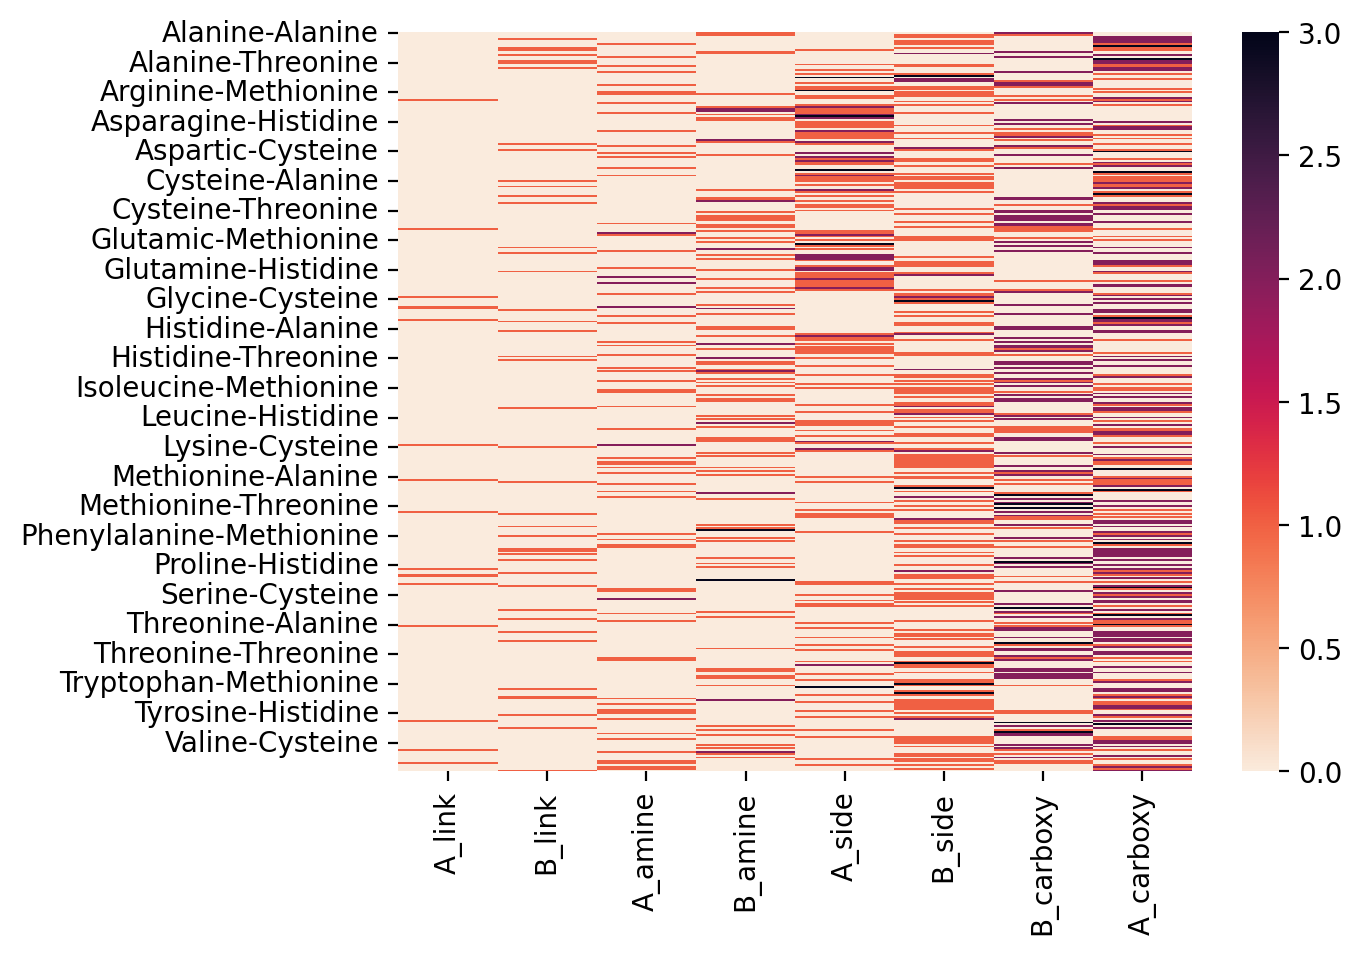

In [43]:
sns.heatmap(data=df_X[df_X.sum().sort_values().index],cmap=sns.cm.rocket_r)
plt.show()

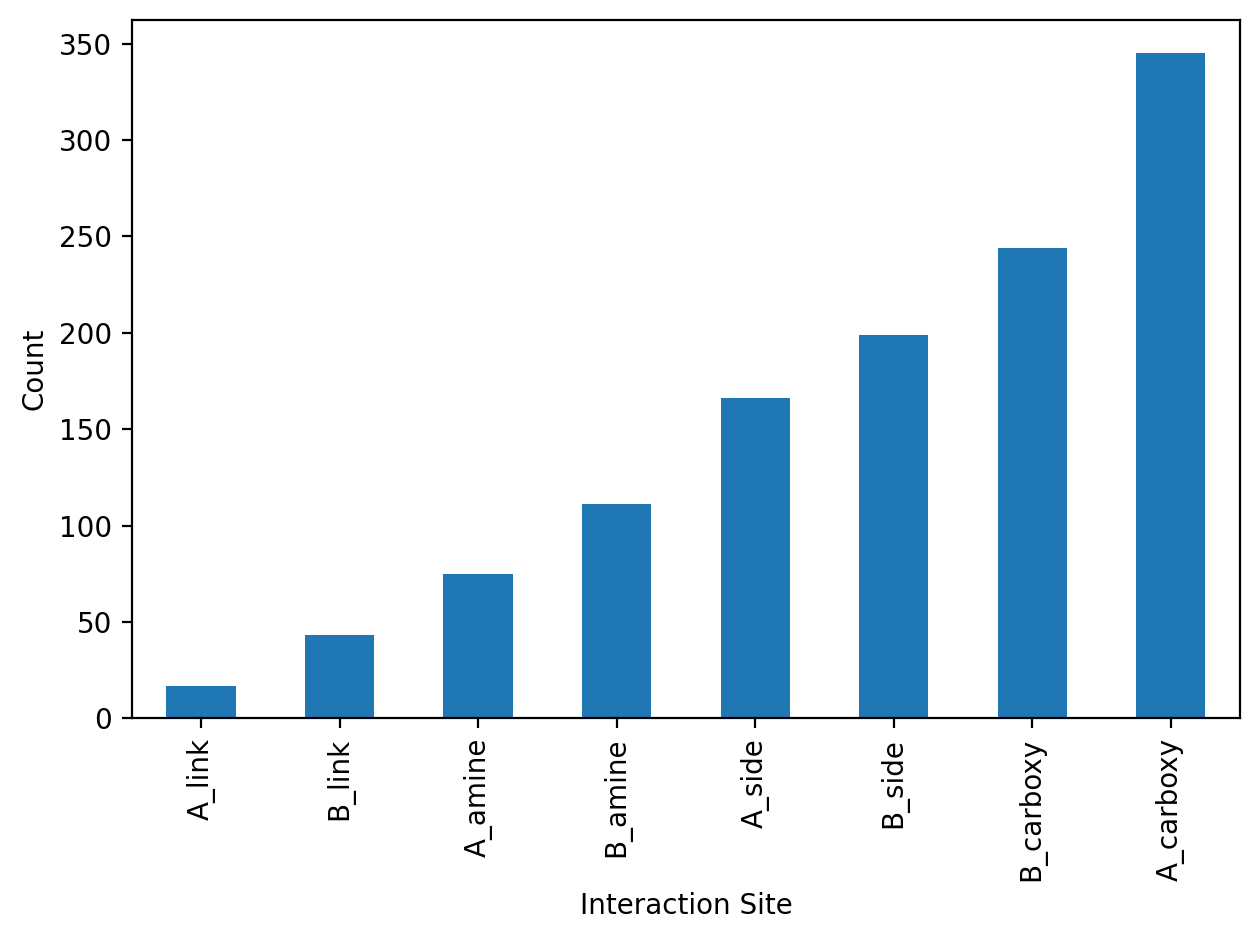

In [44]:
ax=df_X.sum().sort_values().plot.bar()
ax.set_xlabel('Interaction Site')
ax.set_ylabel('Count')
plt.tight_layout()
plt.savefig('interaction_bar.png',dpi=300,bbox_inches='tight')
plt.show()